In [1]:
import numpy as np

In [2]:
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from numpy import linalg
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy import stats
from mayavi import mlab
import seaborn as sns
from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import uniform

In [3]:

from tvtk.api import tvtk




In [4]:
def get_distribution_object(id = 1):
    d_dict = {}
    d_dict[1] = {
        'x': gamma(a = 2, loc= 1.0, scale=0.5),
        'y': gamma(a = 1, loc=-1.0, scale=0.75),
    }
    d_dict[2] = {
        'x': gamma(a = 1.0, loc = -1.5, scale=0.5),
        'y': gamma(a = 2.0, loc = 1.50, scale=0.5),
       
    }
    d_dict[3] = {
        'x': norm(loc = 2.75, scale =0.25),
        'y': norm(loc = 2.75, scale =0.25),
        
    }
    return d_dict[id]


def sample_from_dist(id = 1, size=500):
    obj = get_distribution_object(id)
    x = obj['x'].rvs(size=size)
    y = obj['y'].rvs(size=size)
    xy= np.vstack([x,y]).transpose()
    return xy


/home/ddatta/anaconda3/envs/rp_1/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The following kwargs were not used by contour: 'lw'
  # This is added back by InteractiveShellApp.init_path()
/home/ddatta/anaconda3/envs/rp_1/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The following kwargs were not used by contour: 'lw'
  if sys.path[0] == '':


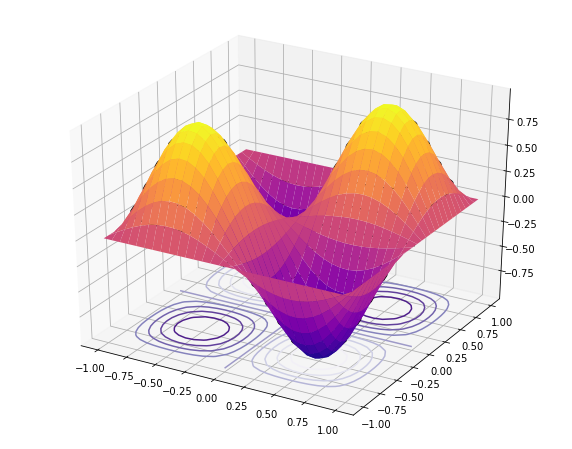

In [17]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:30j, -1:1:30j]
Z = np.sin(np.pi*X)*np.sin(np.pi*Y)

ax.plot_surface(X, Y, Z, cmap="plasma", lw=0.5, rstride=1, cstride=1)
ax.contour(X, Y, Z, 10, lw=3, cmap="Purples", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
plt.show()

In [5]:
X1 = sample_from_dist(id = 1,size = 1000)
X2 = sample_from_dist(id = 2,size = 1000)
X3 = sample_from_dist(id = 3,size = 200)

In [12]:
def  plot_fig(xyz_list , cmaps = None , text_annotations = None):
    figure = mlab.figure('DensityPlot', bgcolor = (1,1,1),fgcolor=(0,0,0))
    if cmaps is None:
        cmaps = ['cool', 'winter','spring', 'pink', 'purples', 'cool' ]
    i = 0
    j = 0
    for _xyz in xyz_list:
        kde1 = stats.gaussian_kde(_xyz.transpose()[:2])
        density = kde1(_xyz.transpose()[:2])
        pts = mlab.points3d(_xyz[:,0], _xyz[:,1], density, density, colormap=cmaps[i],   mode = 'point', scale_mode='none', scale_factor=0.2)
        mesh = mlab.pipeline.delaunay2d(pts)
        surf = mlab.pipeline.surface(mesh, colormap=cmaps[i])
        i = (i+1)% len(cmaps)
        if text_annotations is not None:
            _text = text_annotations[j]
            mlab.text3d(np.mean(_xyz[:,0]) , np.mean(_xyz[:,1]), np.max(density) + 0.25, _text, scale=(0.25, 0.25, 0.25))
            j +=1
            
    figure.scene.disable_render = False
    mlab.axes(z_axis_visibility=False)
    ax=mlab.axes()
    ax.axes.font_factor = 1.0
    mlab.gcf().scene.parallel_projection = True  # Source: <<https://stackoverflow.com/a/32531283/2729627>>.
    mlab.orientation_axes() 
    mlab.show()
    return 

In [29]:
def  plot_fig_v2(xyz_list , cmaps = None , text_annotations = None):
    
    import numpy as np
    from mpl_toolkits.mplot3d import axes3d
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(111, projection="3d")
  
    figure = mlab.figure('DensityPlot', bgcolor = (1,1,1),fgcolor=(0,0,0))
    if cmaps is None:
        cmaps = ['Spectral', 'coolwarm',"plasma" ]
    i = 0
    j = 0
    for _xyz in xyz_list:
        kde1 = stats.gaussian_kde(_xyz.transpose()[:2])
        density = kde1(_xyz.transpose()[:2])
        
        X = _xyz[:,0]
        Y = _xyz[:,1]
        Z = []
        count = X.shape[0]
        for i in range(count):
            for j in range(count):
                Z.append([density[i],density[j]])
        Z = np.array(Z)
        print(Z.shape)
        ax.plot_surface(X, Y, Z, cmap="plasma", lw=0.5, rstride=1, cstride=1)
        ax.contour(X, Y, Z, 10, lw=2, cmap="Purples", linestyles="solid", offset=-1)
        ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
    plt.show()
    
    
        
    return 

In [13]:
plot_fig([X1,X2,X3], cmaps = ['cool', 'cool', 'winter'], text_annotations = ['Cluster 1', 'Cluster 2', 'Anomalies'])


(1000000, 2)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

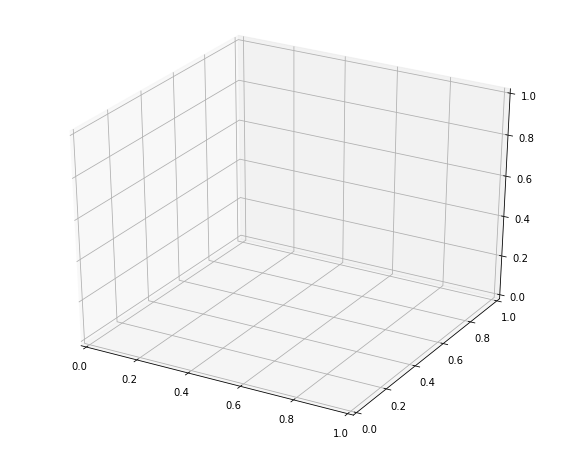

In [30]:
plot_fig_v2([X1,X2,X3], cmaps = ['cool', 'cool', 'winter'], text_annotations = ['Cluster 1', 'Cluster 2', 'Anomalies'])


In [27]:
data = np.vstack([X1,X2])
anomaly_data =  X3
print('Data shapes', data.shape, anomaly_data.shape )

Data shapes (2000, 2) (200, 2)


In [23]:
def calculate_sample_energy(z , phi, mu, cov):
    e = 0
    num_comp = phi.shape[0]
    for k in range(num_comp):
        _mu = np.reshape(mu[0],[-1,1])
        p1 = z.reshape([-1,1]) - _mu 
        p2 = np.linalg.inv(cov[k])
        a = -0.5 * np.matmul( np.matmul ( p1.transpose(), p2), p1 )[0][0]
        b = np.exp(a)
        c = np.sqrt(2 * np.pi * np.linalg.det(cov[k]))
        e_k = phi[k] * b / c
        e += e_k
        
    e = - np.log(e)
    return e 

In [28]:
# ==========================
#  Split normal data
# ==========================
from sklearn.model_selection import train_test_split

train_X, test_X = train_test_split(data,test_size=0.25)

In [29]:
train_X.shape

(1500, 2)

In [30]:
# ================
# Train model 
# ================
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(train_X)
cov = gmm.covariances_
mu = gmm.means_
phi = gmm.weights_

In [31]:
# ---------------------------------------------
# Calculate sample energy for each data point
# ---------------------------------------------
combined_labels = [ 0 for _ in range (test_X.shape[0]) ] + [ 1 for _ in range (anomaly_data.shape[0]) ] 

In [32]:
anomaly_data.shape[0]

200

In [33]:
normal_data_energy = []
for x in test_X:
    e = calculate_sample_energy(x , phi, mu, cov)
    
    normal_data_energy.append(e)

In [34]:
anom_data_energy = []
for x in anomaly_data:
    e = calculate_sample_energy(x , phi, mu, cov)
    anom_data_energy.append(e)

In [35]:
combined_scores = normal_data_energy + anom_data_energy

In [36]:
res_df = pd.DataFrame(data = np.vstack([combined_scores,combined_labels]).transpose(), columns=['score','label'])


def normalize_values(v,_max,_min):
    return (v - _min) / ( _max - _min)

_min = min(combined_scores)
_max = max(combined_scores)

res_df['score'] = res_df['score'].apply(normalize_values,args=(_max,_min))

_min = min(res_df['score'])
_max = max(res_df['score'])

In [37]:
res_df

,score,label
0,0.394629,0.0
1,0.004483,0.0
2,0.166674,0.0
3,0.613188,0.0
4,0.014251,0.0
...,...,...
695,0.316562,1.0
696,0.392472,1.0
697,0.359415,1.0
698,0.368615,1.0


In [38]:
step = 0.01
threshold = _max -step
total_anom_count = anomaly_data.shape[0]
R = [0]
P = []
while threshold > _min:
    sel = res_df.loc[res_df['score']>=threshold]

    correct = len(sel.loc[sel['label'] == 1])
    selected = len(sel)
    prec = correct/selected
    recall = correct/total_anom_count
  
    threshold -=step
    P.append(prec)
    R.append(recall)
P = [P[0]] + P

In [39]:
from sklearn.metrics import auc


In [40]:
auc(R,P)

0.30950773298349654

# ----------------------------------------------------- #

In [41]:
def generate_neg_samples(dist_obj_list, min_x = -5, max_x =5, min_y = -5, max_y = +5, n_samples = 15000):
    n_dist_obj = {
        'x': uniform(loc = min_x, scale = max_x - min_x),
        'y': uniform(loc = min_y, scale = max_y - min_y),
    }
    res = []
    count = 0
    while count < n_samples:
        _x = n_dist_obj['x'].rvs(size=1)[0]
        _y = n_dist_obj['y'].rvs(size=1)[0]
        accept = True
        for D in dist_obj_list:
            p = D['x'].pdf(_x) *  D['y'].pdf(_y) 
            if p > 0.05:
                accept = False
        if accept:
            res.append([_x,_y])
            count +=1
    return np.array(res)
    
    

In [42]:
dist_obj_list = [ get_distribution_object(id = 1), get_distribution_object(id = 2)]

In [43]:
neg_Samples = generate_neg_samples(dist_obj_list )

In [44]:
plot_fig([X1, X2, neg_Samples])

In [45]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [46]:
# clf = MLPClassifier(
#     hidden_layer_sizes=(2,2,),
#     activation='tanh',
#     learning_rate='adaptive',
#     verbose = True
# )

clf = SVC(probability=True)

              

In [47]:
clf_train_X = np.vstack([train_X, neg_Samples])

In [48]:
clf_train_Y = np.array( [1  for _ in range(train_X.shape[0]) ] + [0 for _ in range(neg_Samples.shape[0]) ] )

In [49]:
clf.fit(clf_train_X,clf_train_Y,  )

SVC(probability=True)

In [50]:
test_X_scores = list(clf.predict_proba(test_X)[:,0].reshape(-1))

anom_scores = list(clf.predict_proba(anomaly_data)[:,0].reshape(-1))

In [51]:
anom_scores

[0.9999851415391333,
 0.9999986233240444,
 0.9999948430913723,
 0.9999993430326647,
 0.9999987552784192,
 0.9999914307156401,
 0.9999975492817823,
 0.9999980648731175,
 0.9999125649475036,
 0.9999955460718747,
 0.9999976022383854,
 0.9999985509238309,
 0.9999922207365537,
 0.9999847851323596,
 0.9999896335207163,
 0.9999944414580025,
 0.9999991751184681,
 0.9999887959707591,
 0.9999841164417279,
 0.9999988156848015,
 0.9999991026639565,
 0.9999976852026627,
 0.9999963949118491,
 0.9999980625257319,
 0.9999983076337767,
 0.999997969109999,
 0.9999987511535668,
 0.9999957491693546,
 0.9999798178525778,
 0.9999714720526904,
 0.9999525876879438,
 0.9999990754484611,
 0.9999564828833151,
 0.9999727564143865,
 0.9999984768872167,
 0.9999946573241842,
 0.9999994633625076,
 0.9999979277889413,
 0.9999202897459519,
 0.9999994957337156,
 0.9999995912924642,
 0.9999928078199515,
 0.9999982350942124,
 0.9999904636281578,
 0.9999932697082299,
 0.9999984647614729,
 0.9999997977192518,
 0.99996966447

In [52]:
test_X_scores

[0.26980367844430087,
 0.12576677264543124,
 0.9728743145452416,
 0.26214001509285456,
 0.3129300487096779,
 0.11181331053328096,
 0.09236887229177831,
 0.2584458840046546,
 0.19424151967529718,
 0.14140095452474433,
 0.22136907413834886,
 0.39844836332351846,
 0.11757047144487641,
 0.23823933626356938,
 0.4527633274964997,
 0.12057582579078106,
 0.07841009319448199,
 0.3503731190164306,
 0.0956574445299,
 0.20206938661426851,
 0.11811089924677817,
 0.17331584162067773,
 0.3521667192142525,
 0.20556501514066636,
 0.7827526853519158,
 0.4602384544383575,
 0.9986299667075372,
 0.09526424907038626,
 0.11461080350996346,
 0.9814743205015022,
 0.3961869621910923,
 0.26628609020767197,
 0.31223262315225037,
 0.5802715928506039,
 0.6983425288849473,
 0.19890585047315634,
 0.17002956871185293,
 0.128371222727855,
 0.2913260877567174,
 0.11955341524115085,
 0.3118437123500934,
 0.9991634205001685,
 0.09961290244564158,
 0.08342539667004084,
 0.5443591955339737,
 0.585146492612748,
 0.3014905565

In [53]:
combined_scores =  test_X_scores + anom_scores

In [54]:
combined_labels = [ 0 for _ in range (test_X.shape[0]) ] + [ 1 for _ in range (anomaly_data.shape[0]) ] 
res_df = pd.DataFrame(
    data = np.vstack([combined_scores,combined_labels]).transpose(), 
    columns=['score','label']
)

def normalize_values(v,_max,_min):
    return (v - _min) / ( _max - _min)

_min = min(combined_scores)
_max = max(combined_scores)

res_df['score'] = res_df['score'].apply(normalize_values,args=(_max,_min))

_min = min(res_df['score'])
_max = max(res_df['score'])
print(_min,_max)

0.0 1.0


In [55]:
step = 0.01
threshold = _max - step
total_anom_count = anomaly_data.shape[0]
R = [0]
P = []

In [56]:
while threshold >_min:
    sel = res_df.loc[res_df['score']>=threshold]
    correct = len(sel.loc[sel['label'] == 1])
    selected = len(sel)
   
    prec = correct/selected
    recall = correct/total_anom_count
#     print(threshold, selected, prec, recall)
    threshold -=step
    P.append(prec)
    R.append(recall)

P = [P[0]] + P
print(auc(R,P))

0.9259259259259259
